In [1]:
from slmfunctions.dependencies import *
from slmfunctions.settings import *
from slmfunctions.simulation import *
from slmfunctions.imageprocessing import *
from slmfunctions.phaseretrieval import *
from slmfunctions.slmsuite.slmsuite.holography.analysis import *

from scipy.optimize import curve_fit


# TURN ON FOR EXPERIMENT
 
# from slmfunctions.slmsuite.slmsuite.hardware.slms.meadowlark import Meadowlark
# # Meadowlark.info(verbose = True)
# from slmfunctions.slmsuite.slmsuite.hardware.cameras.thorlabs import ThorCam
# ThorCam.info(verbose=True)
# from slmfunctions.slmsuite.slmsuite.hardware.cameraslms import FourierSLM

# GLOBAL VARIABLES
numpixels = 1300
slmwidth = 1200
slmheight = 1920

In [2]:
# TURN ON FOR EXPERIMENT

# slm = Meadowlark(slm_number =1, _number = 1, wav_um = .631, settle_time_s=.3)
# cam = ThorCam(serial="", verbose=True)
# fs = FourierSLM(cam, slm)
# fs.load_wavefront_calibration(plot=True)


In [30]:
imgname = f"10by10_9spacing_mag3grid" # LOOKUP NAME
load_dir = r'Z:\nsong\NeutralAtoms\Ultracold-Research\GWS_Summer2024\storage'  # For PC
# load_dir = r'C:\cleen\nsong\2-Research\UAC Research\Github\Ultracold-Research\GWS-Summer2024\storage' # For laptop
optimizedout_tweezer = load_from_file(load_dir, f'tweezers{imgname}')
optimizedout_anchors = load_from_file(load_dir, f'anchors{imgname}')

Object loaded from Z:\nsong\NeutralAtoms\Ultracold-Research\GWS_Summer2024\storage\tweezers10by10_9spacing_mag3grid.pkl
Object loaded from Z:\nsong\NeutralAtoms\Ultracold-Research\GWS_Summer2024\storage\anchors10by10_9spacing_mag3grid.pkl


In [31]:
precisetweezerim = remove0thorder(simulatefourier(zeropad(optimizedout_tweezer.get_slmphase(),4096-1300), magnification=1),100)
simulatedcamimage = zoomin(precisetweezerim, 1000).get()
# targettweezers = removenoise(zoomin(intensityimg, 1),10)

In [32]:
preciseanchorim = remove0thorder(simulatefourier(zeropad(optimizedout_anchors.get_slmphase(),4096-1300), magnification=1),100)
simulatedcamimage_anchor = zoomin(preciseanchorim, 10000).get()

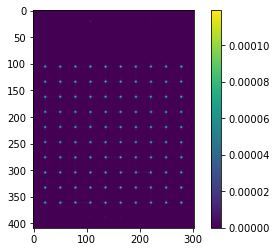

In [39]:
plt.imshow(simulatedcamimage)
plt.colorbar()

In [44]:
def threshold_array(arr, lower_threshold=0.05, upper_threshold=0.95):
    """
    Modify the array such that values greater than the upper threshold are set to 1
    and values less than the lower threshold are set to 0.

    Parameters
    ----------
    arr : numpy.ndarray
        The input array to be modified.
    lower_threshold : float, optional
        The lower threshold, default is 0.05.
    upper_threshold : float, optional
        The upper threshold, default is 0.95.

    Returns
    -------
    numpy.ndarray
        The modified array.
    """
    # Create a copy of the array to avoid modifying the original array
    modified_arr = np.copy(arr)
    
    # Apply the thresholds
    modified_arr[modified_arr > upper_threshold] = 1
    modified_arr[modified_arr < lower_threshold] = 0
    
    return modified_arr

def assign_blob_coordinates(blobs, grid_size):
    # Extract coordinates of detected blobs
    coordinates = np.array([blob.pt for blob in blobs[0]])

    # Sort blobs by y-coordinates first, then by x-coordinates to get initial order
    sorted_indices = np.lexsort((coordinates[:, 0], coordinates[:, 1]))
    sorted_coordinates = coordinates[sorted_indices]

    # Initialize a numpy array to store the coordinates
    blob_coordinates = np.empty(grid_size + (2,), dtype=float)

    # Assign coordinates to the 2D array row by row
    index = 0
    for i in range(grid_size[0]):
        # Sort blobs in each row by x-coordinate
        row_indices = np.argsort(sorted_coordinates[index:index + grid_size[1], 0])
        blob_coordinates[i] = sorted_coordinates[index + row_indices]
        index += grid_size[1]

    return blob_coordinates

# IMPORTANT - Remember how the image conversion for some reason changes the intensity values of the targets. What the fuck?
def assign_tweezer_coordinates(tweezers, grid_size):
    """
    Assigns blob coordinates from an image with blobs as points equal to 1.
    
    Parameters
    ----------
    tweezers : numpy.ndarray
        The 2D numpy array where blobs are represented by points equal to 1.
    grid_size : tuple
        The size of the grid (rows, cols).
        
    Returns
    -------
    blob_coordinates : numpy.ndarray
        A 2D numpy array containing the coordinates of blobs.
    """
    # Find coordinates of points equal to 1
    coordinates = np.argwhere(tweezers > 0.95)
    
    # Sort the coordinates by y (row) and then by x (column)
    sorted_indices = np.lexsort((coordinates[:, 1], coordinates[:, 0]))
    sorted_coordinates = coordinates[sorted_indices]

    # Initialize the blob_coordinates array
    rows, cols = grid_size
    blob_coordinates = np.empty((rows, cols, 2), dtype=int)

    # Assign coordinates to the grid
    for i in range(rows):
        for j in range(cols):
            blob_index = i * cols + j
            if blob_index < len(sorted_coordinates):
                blob_coordinates[i, j] = sorted_coordinates[blob_index]
            else:
                blob_coordinates[i, j] = [-1, -1]  # Fill with invalid coordinates if not enough blobs

    return blob_coordinates

def calculate_distances(blobs, grid_size):
    # Assign blob coordinates to a 2D array
    blob_coordinates = assign_blob_coordinates(blobs, grid_size)
    
    # Initialize arrays to store distances
    horizontal_distances = np.zeros((grid_size[0], grid_size[1] - 1))
    vertical_distances = np.zeros((grid_size[0] - 1, grid_size[1]))

    # Calculate horizontal distances
    for i in range(grid_size[0]):
        for j in range(grid_size[1] - 1):
            horizontal_distances[i, j] = np.linalg.norm(blob_coordinates[i, j + 1] - blob_coordinates[i, j])

    # Calculate vertical distances
    for i in range(grid_size[0] - 1):
        for j in range(grid_size[1]):
            vertical_distances[i, j] = np.linalg.norm(blob_coordinates[i + 1, j] - blob_coordinates[i, j])

    return horizontal_distances, vertical_distances

def plot_distance_distribution(horizontal_distances, vertical_distances, bin_size_percentage=5):
    # Flatten distances to compute histogram
    flat_horizontal = horizontal_distances.flatten()
    flat_vertical = vertical_distances.flatten()

    # Calculate bin sizes based on a percentage of the maximum distance in each set
    max_horizontal_distance = np.max(flat_horizontal)
    max_vertical_distance = np.max(flat_vertical)
    min_horizontal_distance = np.min(flat_horizontal)
    min_vertical_distance = np.min(flat_vertical)


    bin_size_horizontal = max_horizontal_distance * (bin_size_percentage / 100.0)
    bin_size_vertical = max_vertical_distance * (bin_size_percentage / 100.0)

    # Calculate bins based on the calculated bin sizes
    bins_horizontal = np.arange(min_horizontal_distance-bin_size_horizontal, max_horizontal_distance + bin_size_horizontal, bin_size_horizontal)
    bins_vertical = np.arange(min_vertical_distance-bin_size_vertical, max_vertical_distance + bin_size_vertical, bin_size_vertical)

    # Plotting horizontal distances histogram
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.hist(flat_horizontal, bins=bins_horizontal, edgecolor='black')
    plt.title('Horizontal Distance Distribution')
    plt.xlabel('Distance')
    plt.ylabel('Frequency')
    plt.tight_layout(pad=3.0)  # Adjust padding around the plot

    # Plotting vertical distances histogram
    plt.subplot(1, 2, 2)
    plt.hist(flat_vertical, bins=bins_vertical, edgecolor='black')
    plt.title('Vertical Distance Distribution')
    plt.xlabel('Distance')
    plt.ylabel('Frequency')
    plt.tight_layout(pad=3.0)  # Adjust padding around the plot

    # Display plots
    plt.show()

def gaussian_2d(x, y, x0, y0, sigma_x, sigma_y, amplitude, offset):
    """2D Gaussian function."""
    return offset + amplitude * np.exp(
        -(((x - x0) ** 2) / (2 * sigma_x ** 2) + ((y - y0) ** 2) / (2 * sigma_y ** 2))
    )

def fit_gaussian_2d(region):
    """Fit a 2D Gaussian to the given region."""
    y, x = np.indices(region.shape)
    initial_guess = (region.shape[1] // 2, region.shape[0] // 2, 1, 1, np.max(region), np.min(region))
    
    try:
        popt, _ = curve_fit(
            lambda xy, x0, y0, sigma_x, sigma_y, amplitude, offset: gaussian_2d(xy[0], xy[1], x0, y0, sigma_x, sigma_y, amplitude, offset),
            (x.ravel(), y.ravel()),
            region.ravel(),
            p0=initial_guess
        )
        
        fit = gaussian_2d(x, y, *popt)
        residuals = region - fit
        goodness_of_fit = 1 - np.sum(residuals**2) / np.sum((region - np.mean(region))**2)
        return popt, goodness_of_fit
    
    except Exception as e:
        print(f"Error fitting Gaussian: {e}")
        return initial_guess, 0  # Return initial guess and 0 goodness of fit in case of an error

def extract_regions(simulatedcamimage, blob_coordinates, N=3):
    """
    Extract N by N regions centered around each blob, fit a Gaussian, and adjust blob coordinates.

    Parameters
    ----------
    simulatedcamimage : numpy.ndarray
        The original 2D array containing the image data.
    blob_coordinates : numpy.ndarray
        A 2D numpy array containing the coordinates of blobs.
    N : int
        The size of the region to extract (N by N).

    Returns
    -------
    goodness_of_fit_array : numpy.ndarray
        A 2D numpy array containing the goodness of fit values.
    updated_blob_coordinates : numpy.ndarray
        A 2D numpy array containing the updated blob coordinates.
    regions : numpy.ndarray
        A 2D numpy array where each entry corresponds to an N by N region centered around each updated blob.
    """
    num_rows, num_cols = blob_coordinates.shape[:2]
    half_N = N // 2

    regions = np.empty((num_rows, num_cols), dtype=object)
    goodness_of_fit_array = np.zeros((num_rows, num_cols))
    tweezerpower = np.zeros((num_rows, num_cols))
    updated_blob_coordinates = np.zeros_like(blob_coordinates)

    for i in range(num_rows):
        for j in range(num_cols):
            y, x = blob_coordinates[i, j]
            
            # Round coordinates to the nearest integers
            y = int(round(y))
            x = int(round(x))

            # Ensure the region is within bounds and remains centered
            y_start = max(0, y - half_N)
            y_end = min(simulatedcamimage.shape[0], y + half_N + 1)
            x_start = max(0, x - half_N)
            x_end = min(simulatedcamimage.shape[1], x + half_N + 1)

            # Extract the region and pad if necessary
            region = simulatedcamimage[y_start:y_end, x_start:x_end]
            if region.shape[0] < N or region.shape[1] < N:
                padded_region = np.zeros((N, N))
                padded_region[:region.shape[0], :region.shape[1]] = region
                region = padded_region

            regions[i, j] = region

            # Fit a 2D Gaussian to the region
            popt, goodness_of_fit = fit_gaussian_2d(region)
            goodness_of_fit_array[i, j] = goodness_of_fit

            tweezerpower[i,j] = popt[4]
            # tweezerpower[i,j] = cp.mean(region)

            # Update the blob coordinates based on the fitted center
            updated_y = y_start + popt[1]
            updated_x = x_start + popt[0]
            updated_blob_coordinates[i, j] = [updated_y, updated_x]

    # Re-run the region extraction with the updated blob coordinates
    regions = np.empty((num_rows, num_cols), dtype=object)
    for i in range(num_rows):
        for j in range(num_cols):
            y, x = updated_blob_coordinates[i, j]
            
            # Round coordinates to the nearest integers
            y = int(round(y))
            x = int(round(x))

            # Ensure the region is within bounds and remains centered
            y_start = max(0, y - half_N)
            y_end = min(simulatedcamimage.shape[0], y + half_N + 1)
            x_start = max(0, x - half_N)
            x_end = min(simulatedcamimage.shape[1], x + half_N + 1)

            # Extract the region and pad if necessary
            region = simulatedcamimage[y_start:y_end, x_start:x_end]
            if region.shape[0] < N or region.shape[1] < N:
                padded_region = np.zeros((N, N))
                padded_region[:region.shape[0], :region.shape[1]] = region
                region = padded_region

            regions[i, j] = region
        

    return goodness_of_fit_array, updated_blob_coordinates, regions, tweezerpower

def map_blobstotarget_int(tweezer_coordinates, blobintensity_values, target_shape):
    """
    Assign intensity values to a new array of the same size as the target array,
    using the coordinates from the blob_coordinates.

    Parameters
    ----------
    blob_coordinates : numpy.ndarray
        The coordinates of the blobs in a 2D grid.
    intensity_values : numpy.ndarray
        The intensity values extracted from the extract_regions function.
    target_shape : tuple
        The shape of the target array (rows, cols).

    Returns
    -------
    numpy.ndarray
        The target array with assigned intensity values.
    """
    target_array = np.zeros(target_shape)

    for i in range(tweezer_coordinates.shape[0]):
        for j in range(tweezer_coordinates.shape[1]):
            y, x = tweezer_coordinates[i, j]
            if 0 <= y < target_shape[0] and 0 <= x < target_shape[1]:
                target_array[y, x] = blobintensity_values[i, j]
    target_array = target_array / np.max(target_array)
    return target_array

def map_blobstotarget_region(tweezer_coordinates, regions, target_shape, demag_factor):
    """
    Map camera regions to the target array with demagnification by averaging blocks of pixels.

    Parameters
    ----------
    blob_coordinates : numpy.ndarray
        The coordinates of the blobs in a 2D grid.
    regions : numpy.ndarray
        The regions extracted from the extract_regions function.
    target_shape : tuple
        The shape of the target array (rows, cols).
    demag_factor : int
        The demagnification factor for averaging blocks of pixels.

    Returns
    -------
    numpy.ndarray
        The target array with mapped and demagnified regions.
    """
    target_array = np.zeros(target_shape)

    for i in range(tweezer_coordinates.shape[0]):
        for j in range(tweezer_coordinates.shape[1]):
            y, x = tweezer_coordinates[i, j]
            if 0 <= y < target_shape[0] and 0 <= x < target_shape[1]:
                region = regions[i, j]
                # Calculate the average of blocks of pixels
                demag_region = region.reshape((region.shape[0] // demag_factor, demag_factor, -1, demag_factor)).mean(axis=(1, 3))
                target_array[y, x] = demag_region.mean()  # or other desired operation

    target_array = target_array / np.max(target_array)
    return target_array

def FeedbackPen_camerabased(w, mappedblobs, target_im):
    threshold = cp.mean(target_im)
    meantweezervalue = cp.mean(mappedblobs[target_im > threshold])
    w[target_im>threshold] = cp.sqrt(meantweezervalue / mappedblobs[target_im>threshold])
    return w


tweezershape = (10,10)
target_coords = assign_tweezer_coordinates(threshold_array(optimizedout_tweezer.get_uniformtarget().get()), tweezershape)
# plots = plot_distance_distribution(target_hordist, target_vertdist, 1)
# target_gaussfit, target_blobcoords_v2, target_regions, target_tweezerint = extract_regions(simulatedcamimage, target_blobcoords, 9)



camerablobs = blob_detect(simulatedcamimage)
camera_blobcoords= assign_blob_coordinates(camerablobs, tweezershape)
camera_hordist, camera_vertdist = calculate_distances(camerablobs, tweezershape)
# plots = plot_distance_distribution(camera_hordist, camera_vertdist, 1)
camera_gaussfit, camera_blobcoords_v2, camera_regions, camera_tweezerint = extract_regions(simulatedcamimage, camera_blobcoords, 15)

mappedblobs_int = map_blobstotarget_int(target_coords, camera_tweezerint, cp.shape(optimizedout_tweezer.get_targetim().get()))
mappedblobs_region = map_blobstotarget_region(target_coords, camera_regions, cp.shape(optimizedout_tweezer.get_targetim().get()),1)



Error fitting Gaussian: Optimal parameters not found: Number of calls to function has reached maxfev = 1400.
Error fitting Gaussian: Optimal parameters not found: Number of calls to function has reached maxfev = 1400.
Error fitting Gaussian: Optimal parameters not found: Number of calls to function has reached maxfev = 1400.
Error fitting Gaussian: Optimal parameters not found: Number of calls to function has reached maxfev = 1400.
Error fitting Gaussian: Optimal parameters not found: Number of calls to function has reached maxfev = 1400.
Error fitting Gaussian: Optimal parameters not found: Number of calls to function has reached maxfev = 1400.
Error fitting Gaussian: Optimal parameters not found: Number of calls to function has reached maxfev = 1400.
Error fitting Gaussian: Optimal parameters not found: Number of calls to function has reached maxfev = 1400.
Error fitting Gaussian: Optimal parameters not found: Number of calls to function has reached maxfev = 1400.
Error fitting Gauss

C:\Users\USER\AppData\Local\Temp/ipykernel_51324/3665720311.py:169: RuntimeWarning: invalid value encountered in double_scalars
  goodness_of_fit = 1 - np.sum(residuals**2) / np.sum((region - np.mean(region))**2)


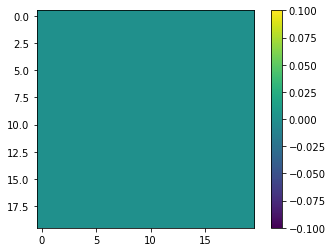

In [35]:
plt.imshow(zoomin(cp.array(mappedblobs_int)).get())
plt.colorbar()

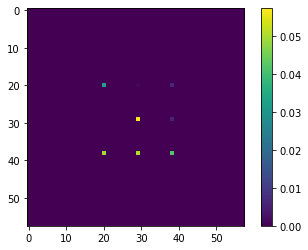

In [58]:
plt.imshow(zoomin(cp.array(mappedblobs_region)).get() - zoomin(cp.array(mappedblobs_int)).get())
plt.colorbar()

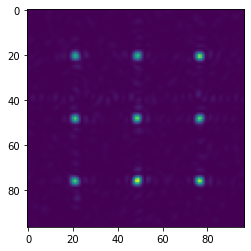

In [36]:
plt.imshow(simulatedcamimage)

In [34]:
def print_blob_coordinates(blobs):
    """
    Print the coordinates of all detected blobs.

    Parameters
    ----------
    blobs : tuple
        A tuple containing the list of KeyPoints and the SimpleBlobDetector object.
    """
    # Extract the list of KeyPoints from the blobs tuple
    keypoints = blobs[0]

    print("Coordinates of detected blobs:")
    for i, blob in enumerate(keypoints):
        print(f"Blob {i}: x = {blob.pt[0]}, y = {blob.pt[1]}")
        
print_blob_coordinates(testblob)

Coordinates of detected blobs:
Blob 0: x = 20.911928176879883, y = 76.55889892578125
Blob 1: x = 48.83226013183594, y = 75.78893280029297
Blob 2: x = 76.31561279296875, y = 75.95011138916016
Blob 3: x = 48.57984924316406, y = 48.488101959228516
Blob 4: x = 21.23944091796875, y = 48.300567626953125
Blob 5: x = 76.32981872558594, y = 48.3043098449707
Blob 6: x = 76.32222747802734, y = 20.49449920654297
Blob 7: x = 48.67172622680664, y = 20.3509578704834
Blob 8: x = 21.06722068786621, y = 20.344568252563477
